In [2]:
from simulation_files.libs.libraries import *
%run simulator.ipynb

scikit-learn has been installed.
All packages are up to date.


network_area:  158.196 km^2
n_tiles:  252280
num_BSs:  734
num_active_users:  100


100%|██████████| 500/500 [02:52<00:00,  2.91it/s]


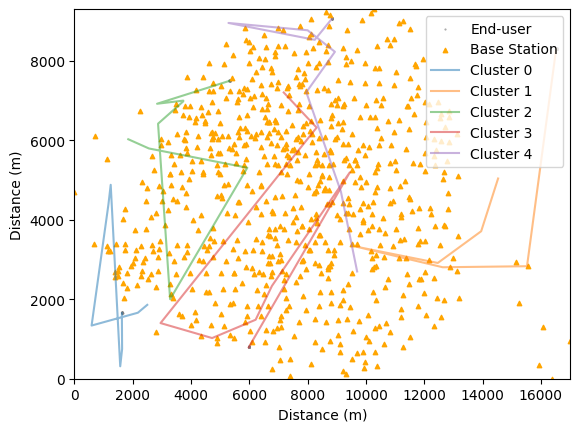

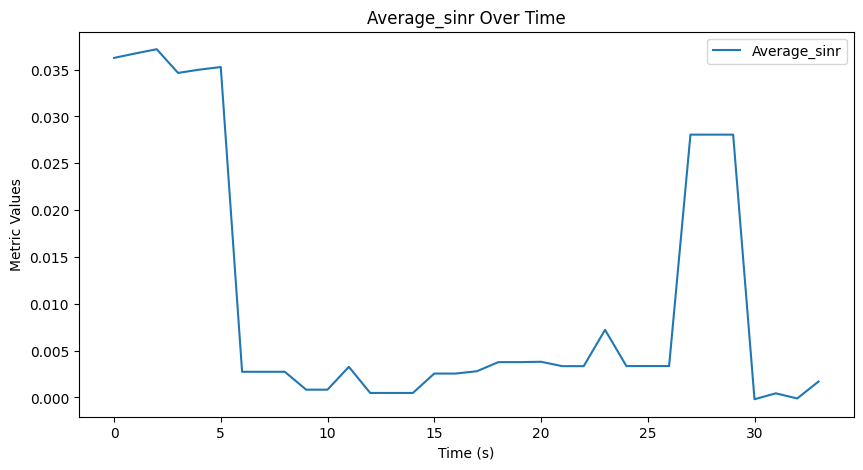

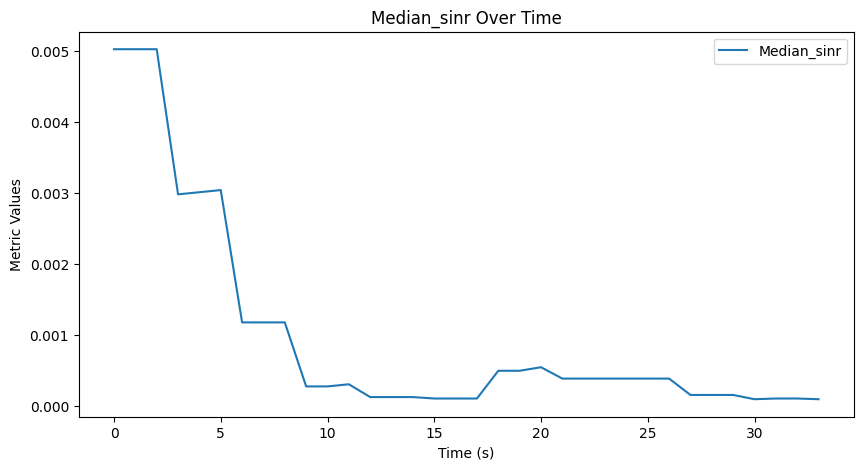

In [6]:
SIM_TIME = 1000
n_clusters = 5
cntr = Controller()
sim = SIMULATION(id = 1, controller=cntr)
sim.run(filepath = "datasets/Filtered_4G_Sites_Orange_Paris.csv",n_clusters=n_clusters, max_cap_= 500, verbose = False)

In [7]:
## Get a realistic visualization

loc = Location("Paris, Île-de-France, France", (48.8566969, 2.3514616), raw= {})
print(loc.address)
print((loc.latitude, loc.longitude))
bss = pd.read_csv("datasets/Paris_4G_Sites_Lat_Long.csv")
bss.head()
m = folium.Map([loc.latitude, loc.longitude], zoom_start=12)

for i, row in bss.iterrows():
    #print(row)
    folium.Marker(
        location=[row["latitude"], row["longitude"]],
        popup=row["id_station_anfr"],
        icon=folium.DivIcon(html=f"""<div style="font-size: 8px; color: blue;"><i class="fa fa-caret-up"></i></div>""")
        #icon=folium.DivIcon(html=f"""<div style="font-size: 5px; color: red;"><i class="fa fa-circle"></i></div>""")
        #icon=folium.DivIcon(html=f"""<div style="color: black; font-size: 16px; font-family: 'Arial';"><i class="fa fa-caret-up"></i></div>""")
    ).add_to(m) # add the marker to the map


legend_html = '''
<div style="position: fixed; 
            top: 25px; right: 25px; width: 100px; height: 60px; 
            border:2px solid grey; z-index:9999; font-size:10px;
            background-color: white; opacity: 0.8; padding: 5px;
            ">&nbsp; Legend <br>
            &nbsp; <span style="font-size: 10px;"><i class="fa fa-caret-up" style="color: blue;"></i>&nbsp; Base Station <br>
            &nbsp; <span style="height: 6px; width: 6px; background-color: red; border-radius: 50%; display: inline-block;"></span>&nbsp; User <br>
</div>
'''
#&nbsp; <span style="font-size: 10px;"><i class="fa fa-circle" style="color: red;"></i>&nbsp; User <br>
# Add the legend HTML to the map
m.get_root().html.add_child(folium.Element(legend_html));
m

Paris, Île-de-France, France
(48.8566969, 2.3514616)


In [8]:
m.save("output/map.html")

## Build a radial-deacy probability matrix

In [9]:
center = Location("Notre Dame, Paris, Île-de-France, France", (48.852737, 2.350699), raw= {})

In [10]:
print(center.address)
print((center.latitude, center.longitude))

Notre Dame, Paris, Île-de-France, France
(48.852737, 2.350699)


In [11]:
def get_geo_coordinate(position: Tuple[float, float])->Tuple[float, float]:
    """
    Get the geographical coordinates given the location and the reference position of origin.

    Returns:
    - tuple: The latitude and longitude of the UE's position.
    """
    # NB
    # source: http://www.edwilliams.org/avform147.htm
    # and https://gis.stackexchange.com/questions/2951/algorithm-for-offsetting-a-latitude-longitude-by-some-amount-of-meters/2980#2980?newreg=0bedc72752ea4e629440a761d6f4a231
    # ORIGIN = (Latitude, Longitude) 
    # self.position = (x, y) in km x=>longitude, y=>latitude

    # Convert latitude and longitude to radians
    lat_rad = math.radians(ORIGIN[0])
    # lon_rad = math.radians(ORIGIN[1])

    # Calculate the change in latitude
    delta_lat = position[1] / earth_radius_km

    # Calculate the change in longitude
    delta_lon = position[0] / (earth_radius_km * math.cos(lat_rad))

    # Convert the changes to degrees
    delta_lat_deg = math.degrees(delta_lat)
    delta_lon_deg = math.degrees(delta_lon)

    # Calculate the new latitude and longitude
    new_latitude = ORIGIN[0] + delta_lat_deg
    new_longitude = ORIGIN[1] + delta_lon_deg

    return new_latitude, new_longitude

In [12]:
def get_tile_geo_coordinate(sim: SIMULATION, tile_loc: int)->Tuple[float, float]:
    row_index = tile_loc // sim.num_tiles_x
    col_index = tile_loc % sim.num_tiles_x

    tile_base_x = col_index * TILE_SIZE
    tile_base_y = row_index * TILE_SIZE

    return get_geo_coordinate((tile_base_x, tile_base_y))

In [13]:
c = np.array((center.latitude, center.longitude)) #to be found as the max flux point

In [14]:
loc = np.array(get_tile_geo_coordinate(sim = sim, tile_loc = 5))

In [15]:
densifier = lambda i, c: np.exp(-l2_norm(np.array(get_tile_geo_coordinate(sim = sim, tile_loc = i))-c))

In [16]:
normalizer = lambda lst: np.array(lst)/np.sum(lst)

In [17]:
densities = [densifier(i, c) for i in range(sim.n_tiles)]

In [18]:
prob_map_ = normalizer([densifier(i, c) for i in range(sim.n_tiles)])

In [19]:
#EXPONENTIAL DISTRIBUTION MAPPING
prob_map_

array([3.73993826e-06, 3.74116219e-06, 3.74238623e-06, ...,
       3.73572133e-06, 3.73454681e-06, 3.73337213e-06])

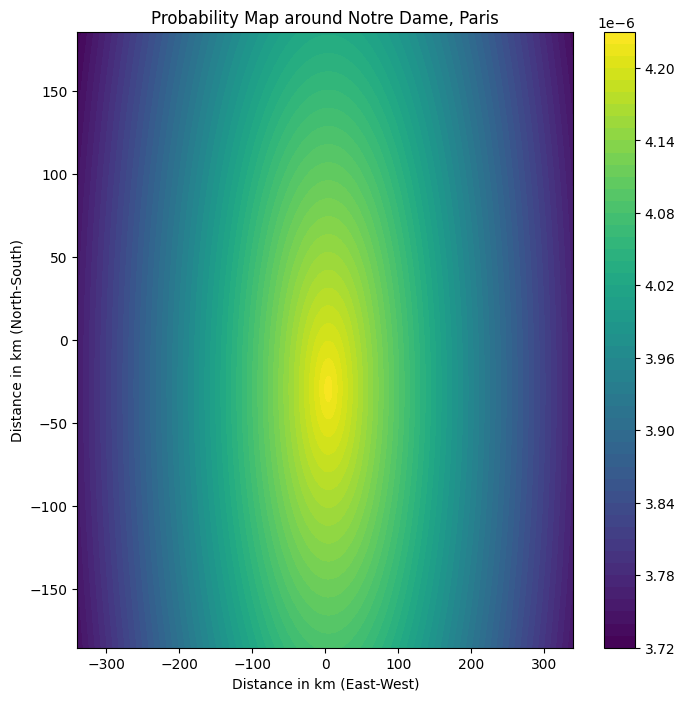

In [20]:
# Plotting Probability Map
x = np.linspace(-sim.num_tiles_x / 2, sim.num_tiles_x / 2, sim.num_tiles_x)
y = np.linspace(-sim.num_tiles_y / 2, sim.num_tiles_y / 2, sim.num_tiles_y)
X, Y = np.meshgrid(x, y)
Z = prob_map_.reshape((int(sim.num_tiles_y), int(sim.num_tiles_x)))

fig, ax = plt.subplots(figsize=(8, 8))
cp = ax.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(cp, ax=ax)
ax.set_title('Probability Map around Notre Dame, Paris')
ax.set_xlabel('Distance in km (East-West)')
ax.set_ylabel('Distance in km (North-South)')
plt.show()

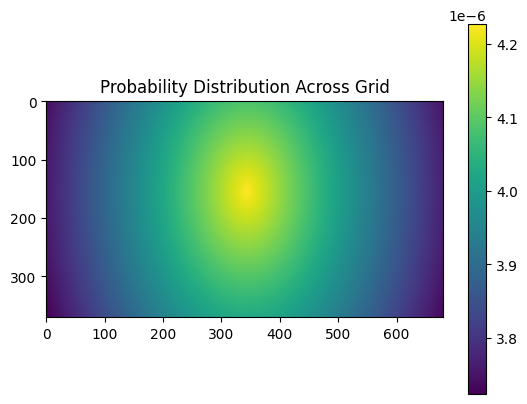

In [21]:
#alternative
plt.imshow(prob_map_.reshape((int(sim.num_tiles_y), int(sim.num_tiles_x))))
plt.colorbar()
plt.title('Probability Distribution Across Grid')
plt.show()

In [22]:
def radial_probability_plot(radius, max_radius, num_circles):
    theta = np.linspace(0, 2*np.pi, 100)
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 8))
    radii = np.linspace(radius, max_radius, num_circles)
    for r in reversed(radii):
        prob = np.exp(-r + radius)  # Exponential decay
        ax.fill(theta, np.full_like(theta, r), alpha=prob, label=f'Radius {r:.1f} km')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title('Radial Probability Distribution with Concentric Circles')
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    plt.show()

network_area:  158.196 km^2
n_tiles:  252280
num_BSs:  734
num_active_users:  500


100%|██████████| 1000/1000 [10:11<00:00,  1.64it/s]


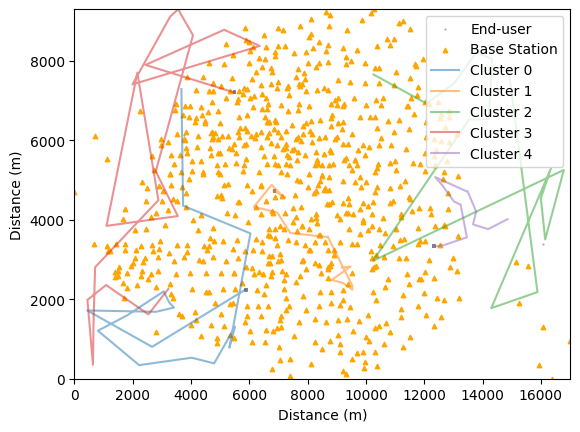

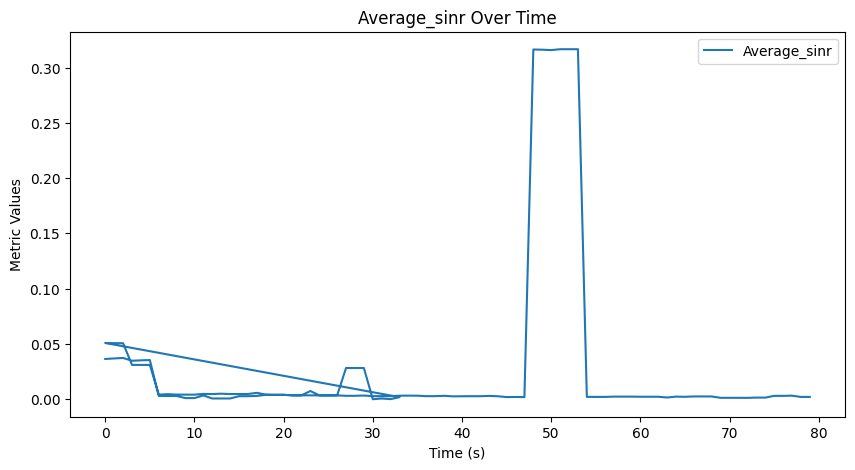

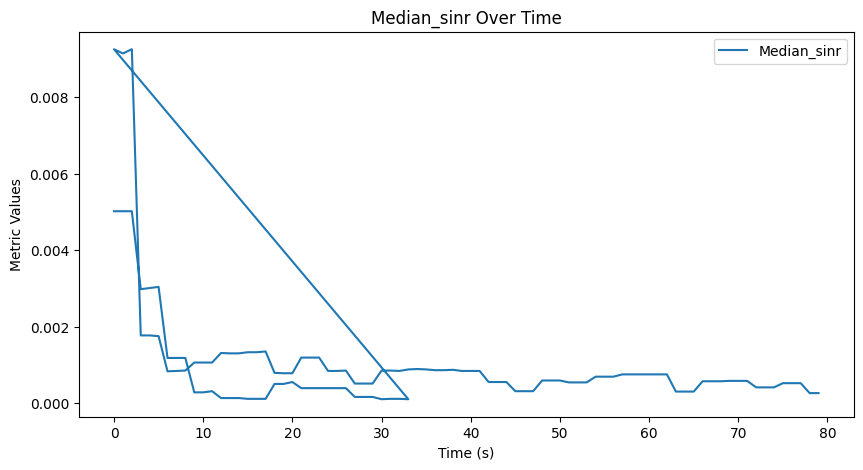

In [24]:
#test the simulator with the radial-basis probability distribution
SIM_TIME = 1000
n_clusters = 5
cntr = Controller()
sim = SIMULATION(id = 1, controller=cntr, prob_map = prob_map_)
sim.run(filepath = "datasets/Filtered_4G_Sites_Orange_Paris.csv",n_clusters=n_clusters, max_cap_= 500, verbose = False)

In [ ]:
#buffer

In [ ]:
# Create a geolocator object
geolocator = Nominatim(user_agent="geoapiExercises")

# Specify the location name
location_name = "Notre Dame, Paris, France"

# Retrieve the location object
location = geolocator.geocode(location_name)

# Print the coordinates
if location:
    print(f"Latitude: {location.latitude}, Longitude: {location.longitude}")
else:
    print("Location not found.")


GeocoderUnavailable: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Notre+Dame%2C+Paris%2C+France&format=json&limit=1 (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)')))

In [ ]:
def probabilisticmobility_model(initial_pos: Optional(Tuple[float, float])= None, grid_prob_map: List, transpot_prob_map: List)->List[Tuple[float, float]]:
    """
    For a given user it generates the full trajectory that the user will follow.
    """
    position = initial_pos if initial_pos is not None else (0, 0)
    new_pos = None
    trajectory = [position]

    #need to include velocity factor...

    while True:
        
        old_tile = get_tile_loc(position)
        next_tile_pos = argmax((transpot_prob_map.transpose()*transpot_prob_map[old_tile])/grid_prob_map[old_tile])
        tile_position = next_tile_pos

        yield new_pos
    


In [6]:
lst = [2,5,6,1,3]
lst

[2, 5, 6, 1, 3]

In [10]:
(np.array(lst)**2)/2

array([ 2. , 12.5, 18. ,  0.5,  4.5])